<a href="https://colab.research.google.com/github/JustAlex5/deep_learning/blob/main/Final_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,Input
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model

import numpy as np
from tensorflow.keras.layers import SimpleRNN, LSTM ,RepeatVector,Reshape# <--- recurrent layers
from tensorflow.keras.utils import to_categorical
import re
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img
from PIL import Image

from keras.applications.vgg16 import VGG16
print(tf.__version__)

2.7.0


11501568/11490434 [==============================] - 0s 0us/step
MNIST_train_images.shape = (60000, 28, 28, 1)
MNIST_train_labels.shape = (60000,)
MNIST_test_images.shape = (10000, 28, 28, 1)
MNIST_test_labels.shape = (10000,)


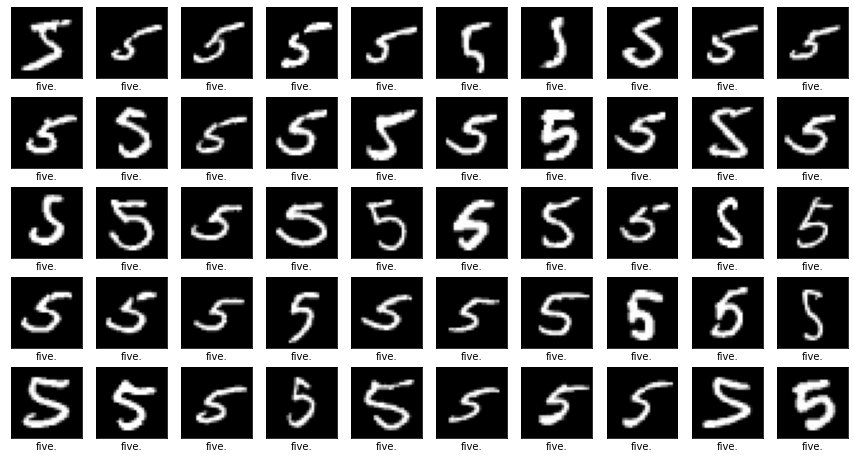

In [ ]:
(MNIST_train_images, MNIST_train_labels), (MNIST_test_images, MNIST_test_labels) = tf.keras.datasets.mnist.load_data()

# 2. flatten the labels (easier to deal with)
MNIST_train_labels = MNIST_train_labels.flatten()  # (50000, 1) -> (50000,)
MNIST_test_labels = MNIST_test_labels.flatten()    # (10000, 1) -> (10000,)

# 3. convert uint8->float32 and normalize range to 0.0-1.0 
MNIST_train_images = MNIST_train_images.astype('float32') / 255.0
MNIST_test_images = MNIST_test_images.astype('float32') / 255.0

# 4. expand the dimensions (tensorflow expects images in a (H,W,C) format):
# (Height, Width, Channel), in our case we have 3 color channels (R,G,B)
MNIST_train_images = MNIST_train_images[...,None]
MNIST_test_images = MNIST_test_images[..., None]

# 5. print the shapes
print('MNIST_train_images.shape =',MNIST_train_images.shape)
print('MNIST_train_labels.shape =',MNIST_train_labels.shape)
print('MNIST_test_images.shape =',MNIST_test_images.shape)
print('MNIST_test_labels.shape =',MNIST_test_labels.shape)


class_names = ['zero.','one.', 'two.', 'three.', 'four.', 'five.',
               'six.', 'seven.', 'eight.', 'nine.']

# 6. lets plot some "5"s (just for fun)
[idx] = np.where(MNIST_train_labels==5) # find all the "5"s
plt.figure(figsize=(15,8))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(MNIST_train_images[idx[i],:,:,0], cmap='gray')
    plt.xlabel(class_names[MNIST_train_labels[idx[i]]])
    plt.xticks([]), plt.yticks([])

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(MNIST_train_images, MNIST_train_labels, epochs=5, 
                    validation_data=(MNIST_test_images, MNIST_test_labels))



Epoch 1/5
1875/1875 [==============================] - 15s 3ms/step - loss: 0.1511 - accuracy: 0.9529 - val_loss: 0.0442 - val_accuracy: 0.9851
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0481 - accuracy: 0.9849 - val_loss: 0.0366 - val_accuracy: 0.9888
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0338 - accuracy: 0.9893 - val_loss: 0.0312 - val_accuracy: 0.9892
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0269 - accuracy: 0.9917 - val_loss: 0.0394 - val_accuracy: 0.9886
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0204 - accuracy: 0.9934 - val_loss: 0.0265 - val_accuracy: 0.9922


313/313 - 1s - loss: 0.0265 - accuracy: 0.9922 - 554ms/epoch - 2ms/step


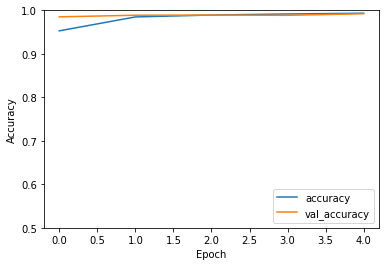

In [ ]:


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(MNIST_test_images,  MNIST_test_labels, verbose=2)



In [ ]:
chars =  ['*','.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [ ]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

ix_to_char

{0: '*',
 1: '.',
 2: 'a',
 3: 'b',
 4: 'c',
 5: 'd',
 6: 'e',
 7: 'f',
 8: 'g',
 9: 'h',
 10: 'i',
 11: 'j',
 12: 'k',
 13: 'l',
 14: 'm',
 15: 'n',
 16: 'o',
 17: 'p',
 18: 'q',
 19: 'r',
 20: 's',
 21: 't',
 22: 'u',
 23: 'v',
 24: 'w',
 25: 'x',
 26: 'y',
 27: 'z'}

In [ ]:
y_test=[]
y_train=[]

In [ ]:
for i in range(len(MNIST_test_labels)):
  y_test.append(class_names[MNIST_test_labels[i]])

for i in range(len(MNIST_train_labels)):
  y_train.append(class_names[MNIST_train_labels[i]])
                      

In [ ]:
chars=' .*abcdefghijklmnopqrstuvwxyz'
class_names = ['zero','one', 'two', 'three', 'four', 'five','six', 'seven', 'eight', 'nine']
char_to_ix= {ch:i for i,ch in enumerate(chars)}
ix_to_char={i:ch for i,ch in enumerate(chars)}

X = np.zeros((len(MNIST_train_images), 10, len(chars)), dtype='bool')
Y = np.zeros((len(MNIST_train_images),10,len(chars)), dtype='bool')


for i, seq in enumerate(y_train):
    for t, char in enumerate(seq):
        if t==0:
            X[i, 0, char_to_ix['*']] = 1
            X[i, t+1, char_to_ix[char]] = 1
            Y[i,0, char_to_ix[char]] = 1
        Y[i,t, char_to_ix[char]]=1
        if char=='.':
            break
        X[i, t+1, char_to_ix[char]] = 1
    X[i,t+1:,char_to_ix[' ']]=1
    Y[i,t:,char_to_ix[' ']]=1


In [ ]:
[ix_to_char[i] for i in np.argmax(Y[1000]+0, axis=1)]

['z', 'e', 'r', 'o', ' ', ' ', ' ', ' ', ' ', ' ']

In [ ]:
[ix_to_char[i] for i in np.argmax(X[1000]+0, axis=1)]

['*', 'z', 'e', 'r', 'o', ' ', ' ', ' ', ' ', ' ']

In [ ]:
encoder_inputs = Input(shape=(28, 28, 1))
encoder = models.Sequential()
for layer in model.layers[:-1]: # go through until last layer
    encoder.add(layer)
encoder.add(layers.Dense(16, activation='softmax'))

for layer in encoder.layers[:-1]: # go through until last layer
    layer.trainable = False

encoder_states = encoder(encoder_inputs)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, len(chars)))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_rnn = SimpleRNN(16, return_sequences=True)
decoder_outputs= decoder_rnn(decoder_inputs, initial_state=encoder_states)
decoder_dense = layers.Dense(len(chars), activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
full_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 29)]   0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 16)           93712       ['input_1[0][0]']                
                                                                                                  
 simple_rnn (SimpleRNN)         (None, None, 16)     736         ['input_2[0][0]',                
                                                                  'sequential_1[0][0]']       

In [ ]:
chars=' .*abcdefghijklmnopqrstuvwxyz'
class_names = ['zero','one', 'two', 'three', 'four', 'five','six', 'seven', 'eight', 'nine']
char_to_ix= {ch:i for i,ch in enumerate(chars)}
ix_to_char={i:ch for i,ch in enumerate(chars)}

X_test = np.zeros((len(MNIST_test_images), 10, len(chars)), dtype='bool')
Y_test = np.zeros((len(MNIST_test_images),10,len(chars)), dtype='bool')


for i, seq in enumerate(y_test):
    for t, char in enumerate(seq):
        if t==0:
            X_test[i, 0, char_to_ix['*']] = 1
            X_test[i, t+1, char_to_ix[char]] = 1
            Y_test[i,0, char_to_ix[char]] = 1
        Y_test[i,t, char_to_ix[char]]=1
        if char=='.':
            break
        X_test[i, t+1, char_to_ix[char]] = 1
    X_test[i,t+1:,char_to_ix[' ']]=1
    Y_test[i,t:,char_to_ix[' ']]=1

In [ ]:
full_model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history=full_model.fit([MNIST_train_images, X],Y,batch_size=64,epochs=5,verbose=1, validation_data=([MNIST_test_images,X_test],Y_test))

Epoch 1/5
938/938 [==============================] - 9s 9ms/step - loss: 0.9875 - accuracy: 0.8244 - val_loss: 0.4261 - val_accuracy: 0.9386
Epoch 2/5
938/938 [==============================] - 8s 8ms/step - loss: 0.3546 - accuracy: 0.9420 - val_loss: 0.3255 - val_accuracy: 0.9508
Epoch 3/5
938/938 [==============================] - 8s 9ms/step - loss: 0.3090 - accuracy: 0.9585 - val_loss: 0.2912 - val_accuracy: 0.9767
Epoch 4/5
938/938 [==============================] - 8s 9ms/step - loss: 0.2589 - accuracy: 0.9892 - val_loss: 0.2328 - val_accuracy: 0.9936
Epoch 5/5
938/938 [==============================] - 8s 9ms/step - loss: 0.2201 - accuracy: 0.9965 - val_loss: 0.2143 - val_accuracy: 0.9968


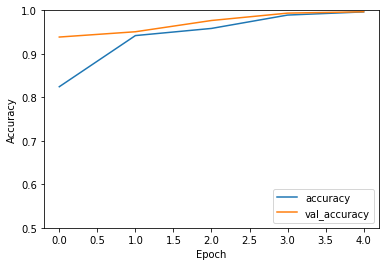

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test= full_model.predict([MNIST_test_images,X_test])

In [ ]:
for index in np.argmax(test[1] , axis=1):
  print(ix_to_char[index])

t
w
o
 
 
 
 
 
 
 


In [ ]:
y_test[1]

'two.'

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

!unzip -qq Flickr8k_Dataset.zip

!unzip -qq Flickr8k_text.zip

^C
[Flickr8k_Dataset.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of Flickr8k_Dataset.zip or
        Flickr8k_Dataset.zip.zip, and cannot find Flickr8k_Dataset.zip.ZIP, period.


In [ ]:
!  ! ls

CrowdFlowerAnnotations.txt  Flickr8k.lemma.token.txt  Flickr_8k.trainImages.txt
ExpertAnnotations.txt	    Flickr_8k.testImages.txt  __MACOSX
Flickr8k_Dataset.zip	    Flickr8k_text.zip	      readme.txt
Flickr_8k.devImages.txt     Flickr8k.token.txt	      sample_data


https://stackoverflow.com/questions/52933222/how-to-combine-rnn-with-cnn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_path="/content/drive/MyDrive/Fina_Prj/Flicker8k_Dataset/"

In [ ]:
txt_path="/content/drive/MyDrive/Fina_Prj/Flickr8k_text/"

In [ ]:
dict={}
data = open(txt_path+'Flickr8k.lemma.token.txt', 'r')

lines= data.readlines()
max_seq=0
# creat dictionary of images (train and test)
# each img contain all the descriptions 
# convert to lower case and delete new line char
for line in lines:
    a,b=line.split("\t",1)
    a=a.split("#")
    if a[0]  in dict.keys():
        b=re.sub(r'[^a-zA-Z0-9 ]',r'',b.lower())
        b='<strat> '+b+' <stop>'
        dict[a[0]].append(b)
    else: 
        b=re.sub(r'[^a-zA-Z0-9 ]',r'',b.lower())
        b='<strat> '+b+' <stop>'
        dict.update({a[0]:[b]})

train_dict={}

# open the train images list
data_train = open(txt_path+'Flickr_8k.trainImages.txt', 'r')
lines= data_train.readlines()
# copy the descriptions of only train images to new dictionary
for line in lines:
    line=line.replace('\n','')
    if line in dict.keys():
        train_dict[line]=dict[line]

words={}
new_word={}
train_dict_new={}
# count all word in the end there dictionary with all words in the train and times that repeats 
for key_item in train_dict:
    value_item= train_dict[key_item]
    tmp_item=" ".join(value_item)
    tmp_item=tmp_item.split(" ")
    for item in tmp_item:
        if item in words.keys():
            words.update({item:words.get(item)+1})
        else:
            words.update({item:1})
for key_item in words:
    value_item= words[key_item]
    if value_item >5:
        # copy all words to new dictionary 
        new_word[key_item]=words[key_item]
    else:
        print(key_item)
# delete all words that apears less than 5 times 
for key_item in train_dict:
    value_item=train_dict[key_item]
    tmp_string=",".join(value_item)
    tmp_string=tmp_string.split(",")
    res=[]
    for item in tmp_string:
        a=[]
        items=item.split(" ")
        if len(items)>max_seq:
            max_seq=len(items)
        for item in items:
            if item in new_word.keys():
                a.append(item)
            else:
                print(item)
        res.append(a)
        train_dict_new.update({key_item:res})   
final_dict={}
idx_word={}
for x,y in enumerate(new_word):
    final_dict.update({y:x+1})
    idx_word.update({x+1:y})

X = np.zeros((len(train_dict_new),len(value_item),  max_seq), dtype='int')
Y = np.zeros((len(train_dict_new),len(value_item),  max_seq), dtype='int')


for j,seqs in enumerate(train_dict_new.items()):
    for   i, seq in enumerate(seqs[1]):
        for t, word in enumerate(seq):
            if t==0:
                X[j,i,t]=final_dict[word]
                continue
            if word=='<stop>':
                Y[j,i,t]=final_dict[word]
            X[j,i,t]=final_dict[word]
            Y[j,i,t-1]=final_dict[word]

In [ ]:
train_images=load_images(train_dict_new.items())

In [ ]:
train_images=np.array(train_images)

In [ ]:
def load_images(pics_name):

  images = []

  for j,seqs in enumerate(train_dict_new.items()):

    image = load_img(f'/content/drive/MyDrive/Fina_Prj/Flicker8k_Dataset/{seqs[0]}', color_mode="rgb", target_size=(229, 229, 3))

    img_2_arr = img_to_array(image) / 255

    images.append(np.array(img_2_arr))

  return images

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(229,229, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))







In [ ]:
encoder_inputs = Input(shape=(229, 229, 3))
encoder = models.Sequential()
for layer in model.layers[:-1]: # go through until last layer
    encoder.add(layer)
encoder.add(layers.Dense(16, activation='softmax'))

for layer in encoder.layers[:-1]: # go through until last layer
    layer.trainable = False

encoder_states = encoder(encoder_inputs)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, max_seq))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_rnn = SimpleRNN(16, return_sequences=True)
decoder_outputs= decoder_rnn(decoder_inputs, initial_state=encoder_states)
decoder_dense = layers.Dense(max_seq, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
full_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
train_images.shape

(6000, 229, 229, 3)

In [ ]:
full_model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history=full_model.fit([train_images, X],Y,batch_size=128,epochs=20,verbose=1)

InternalError: ignored

In [ ]:
from keras.applications.vgg16 import VGG16


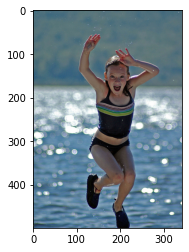

In [ ]:
flickr_train=[]
image = Image.open(image_path+'2671602981_4edde92658.jpg')
image_array = np.array(image)
plt.imshow(image_array)



 

In [ ]:
def load_images(pics_name):

  images = []

  for name in pics_name:

    img = tf.io.read_file(f'/content/drive/MyDrive/final_project/pics/Flicker8k_Dataset/{name}')

    img = tf.image.decode_jpeg(img, channels=3)

    images.append(img.numpy())

  return images